# Data Loading

#Andrea Fassbender
#10/17/2019

In [1]:
%matplotlib inline

import xarray as xr
import matplotlib.pyplot as plt
import intake
import cartopy.crs as ccrs
import numpy as np

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


## Demonstrate how to use `intake-esm`
[Intake-esm](https://intake-esm.readthedocs.io) is a data cataloging utility that facilitates access to CMIP data. It's pretty awesome.

An `intake-esm` collection object establishes a link to a database that contains file locations and associated metadata (i.e. which experiement, model, etc. thet come from). 

### Opening a collection
First step is to open a collection by pointing to the collection definition file, which is a JSON file that conforms to the [ESM Collection Specification](https://github.com/NCAR/esm-collection-spec). 

The collection JSON files are stored locally in this repository for purposes of reproducibility---and because Cheyenne compute nodes don't have Internet access. 

The primary source for these files is the [intake-esm-datastore](https://github.com/NCAR/intake-esm-datastore) repository. Any changes made to these files should be pulled from that repo. For instance, the Pangeo cloud collection is available [here](https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json).

In [2]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

glade-cmip6-ESM Collection with 1115856 entries:
	> 17 activity_id(s)

	> 24 institution_id(s)

	> 48 source_id(s)

	> 82 experiment_id(s)

	> 163 member_id(s)

	> 35 table_id(s)

	> 1029 variable_id(s)

	> 12 grid_label(s)

	> 59 dcpp_init_year(s)

	> 251 version(s)

	> 7799 time_range(s)

	> 1115856 path(s)

`intake-esm` is build on top of [pandas](https://pandas.pydata.org/pandas-docs/stable). It is possible to view the `pandas.DataFrame` as follows.

In [3]:
#col.df.head()

It is possible to interact with the `DataFrame`; for instance, we can see what the "attributes" of the datasets are by printing the columns.

In [4]:
#col.df.columns

In [5]:
#col.df.variable_id

### Search and discovery

#### Finding unique entries
Let's query the data to see what models ("source_id"), experiments ("experiment_id") and temporal frequencies ("table_id") are available.

In [6]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 82,
                   'values': ['ssp370', 'histSST-piNTCF', 'histSST',
                              'histSST-1950HC', 'hist-1950HC', 'hist-piNTCF',
                              'piClim-NTCF', 'ssp370SST-lowNTCF',
                              'ssp370-lowNTCF', 'ssp370SST', '1pctCO2-bgc',
                              'hist-bgc', 'esm-ssp585', '1pctCO2-cdr',
                              'amip-future4K', 'amip-m4K', 'a4SST', 'aqua-p4K',
                              'piSST', 'amip-4xCO2', 'a4SSTice', 'amip-p4K',
                              'aqua-control', 'aqua-4xCO2', 'abrupt-4xCO2',
                              'historical', 'piControl', 'amip', '1pctCO2',
                              'esm-hist', 'esm-piControl', 'ssp245', 'ssp585',
                              'ssp126', 'hist-GHG', 'hist-aer', 'hist-nat',
                              'dcppA-hindcast', 'dcppC-hindcast-noPinatubo',
                              'dcppC-hindcast-noElChichon', 'dcppA-

#### Searching for specific datasets

Let's find all the column integrated npp data at monthly frequency. A quick check of the avaialble data indicates that only historical data are available at present for this variable. https://docs.google.com/spreadsheets/d/1jn_FzGLw7GluO4sH_NHPIJ0R757b-LP-zV0ThSKvXDM/edit#gid=790478368 

Use only 1st member of ensemble: r1i1p1f1

In [7]:
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Omon', variable_id='intpp', member_id='r1i1p1f1', grid_label='gn')
#cat.df

In [8]:
models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical', 'ssp585']:
    query = dict(experiment_id=experiment_id, table_id='Omon', 
                 variable_id='intpp', grid_label='gn', member_id='r1i1p1f1')  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

# for oxygen, ensure the CESM2 models are not included (oxygen was erroneously submitted to the archive)
# models = models - {'CESM2-WACCM', 'CESM2'}

models = list(models)
models

['IPSL-CM6A-LR', 'CESM2', 'CESM2-WACCM']

In [9]:
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Omon', 
                 variable_id='intpp', grid_label='gn', member_id='r1i1p1f1', source_id=models)
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
50843,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,Omon,intpp,gn,NaN,v20190808,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2-...
97622,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,intpp,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
553132,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Omon,intpp,gn,NaN,v20180803,185001-201412,/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-C...
1031437,ScenarioMIP,NCAR,CESM2-WACCM,ssp585,r1i1p1f1,Omon,intpp,gn,NaN,v20190815,201501-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/NCAR...
1042470,ScenarioMIP,NCAR,CESM2,ssp585,r1i1p1f1,Omon,intpp,gn,NaN,v20190730,206501-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/NCAR...
1042471,ScenarioMIP,NCAR,CESM2,ssp585,r1i1p1f1,Omon,intpp,gn,NaN,v20190730,201501-206412,/glade/collections/cmip/CMIP6/ScenarioMIP/NCAR...
1115511,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp585,r1i1p1f1,Omon,intpp,gn,NaN,v20190119,201501-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/IPSL...


Now perform the same steps to get the gridcell area. [areacello] Grid-Cell Area for Ocean Variables

In [10]:
#list models with intpp
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Omon',
                 variable_id='intpp', member_id='r1i1p1f1', grid_label='gn',source_id='CESM2')
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
97622,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,intpp,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
1042470,ScenarioMIP,NCAR,CESM2,ssp585,r1i1p1f1,Omon,intpp,gn,NaN,v20190730,206501-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/NCAR...
1042471,ScenarioMIP,NCAR,CESM2,ssp585,r1i1p1f1,Omon,intpp,gn,NaN,v20190730,201501-206412,/glade/collections/cmip/CMIP6/ScenarioMIP/NCAR...


In [11]:
#list models with ocean grid cell area
cat2 = col.search(experiment_id=['historical', 'ssp585'], table_id='Ofx', 
                  variable_id='areacello', member_id='r1i1p1f1', grid_label='gn', source_id='CESM2')
cat2.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
96988,CMIP,NCAR,CESM2,historical,r1i1p1f1,Ofx,areacello,gn,NaN,v20190308,NaN,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
1041964,ScenarioMIP,NCAR,CESM2,ssp585,r1i1p1f1,Ofx,areacello,gn,NaN,v20190730,NaN,/glade/collections/cmip/CMIP6/ScenarioMIP/NCAR...


### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [12]:
#intpp data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': True})

#ocean grid cell area data
dset_dict2 = cat2.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': True})


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'intpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'intpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,



xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


`dset_dict` is a dictionary of `xarray.Dataset`'s; its keys are constructed to refer to compatible groups.

In [13]:
#intpp keys
dset_dict.keys()

dict_keys(['CMIP.NCAR.CESM2.historical.Omon.gn', 'ScenarioMIP.NCAR.CESM2.ssp585.Omon.gn'])

In [14]:
#ocean grid cell area keys
dset_dict2.keys()

dict_keys(['CMIP.NCAR.CESM2.historical.Ofx.gn', 'ScenarioMIP.NCAR.CESM2.ssp585.Ofx.gn'])

We can access these datasets as follows.

In [15]:
ds_hist = dset_dict['CMIP.NCAR.CESM2.historical.Omon.gn']
ds_85 = dset_dict['ScenarioMIP.NCAR.CESM2.ssp585.Omon.gn']
ds_hist_oa = dset_dict2['CMIP.NCAR.CESM2.historical.Ofx.gn']
ds_85_oa = dset_dict2['ScenarioMIP.NCAR.CESM2.ssp585.Ofx.gn']
ds_lon = ds_85.lon
ds_lat = ds_85.lat

In [16]:
ds_lat

<xarray.DataArray 'lat' (nlat: 384, nlon: 320)>
dask.array<open_dataset-7f646d156a159291443efd7649b1d437lat, shape=(384, 320), dtype=float64, chunksize=(384, 320), chunktype=numpy.ndarray>
Coordinates:
  * nlat     (nlat) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * nlon     (nlon) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
Attributes:
    axis:           Y
    bounds:         lat_bnds
    standard_name:  latitude
    title:          Latitude
    type:           double
    units:          degrees_north
    valid_max:      90.0
    valid_min:      -90.0

# Plot integrated npp at one location over time

In [17]:
def find_indices(xgrid, ygrid, xpoint, ypoint):
   """Returns the i, j index for a latitude/longitude point on a grid.
   .. note::
       Longitude and latitude points (``xpoint``/``ypoint``) should be in the same
       range as the grid itself (e.g., if the longitude grid is 0-360, should be
       200 instead of -160).
   Args:
       xgrid (array_like): Longitude meshgrid (shape M, N)
       ygrid (array_like): Latitude meshgrid (shape M, N)
       xpoint (int or double): Longitude of point searching for on grid.
       ypoint (int or double): Latitude of point searching for on grid.
   Returns:
       i, j (int):
           Keys for the inputted grid that lead to the lat/lon point the user is
           seeking.
   Examples:
       >>> import esmtools as et
       >>> import numpy as np
       >>> x = np.linspace(0, 360, 37)
       >>> y = np.linspace(-90, 90, 19)
       >>> xx, yy = np.meshgrid(x, y)
       >>> xp = 20
       >>> yp = -20
       >>> i, j = et.spatial.find_indices(xx, yy, xp, yp)
       >>> print(xx[i, j])
       20.0
       >>> print(yy[i, j])
       -20.0
   """
   dx = xgrid - xpoint
   dy = ygrid - ypoint
   reduced_grid = abs(dx) + abs(dy)
   min_ix = np.nanargmin(reduced_grid)
   i, j = np.unravel_index(min_ix, reduced_grid.shape)
   return i, j

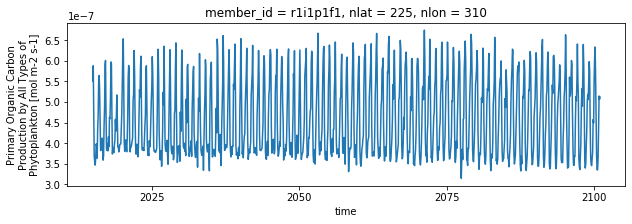

In [32]:
[x,y]=find_indices(ds_lon, ds_lat, 360-145, 50)
ds_85_sub = ds_85.intpp.isel(nlon=x,nlat=y) 

fig = plt.figure(figsize=(10,3))
ds_85_sub.plot()

Text(0.5, 1.0, 'May 2100 - May 2015 IntNPP')

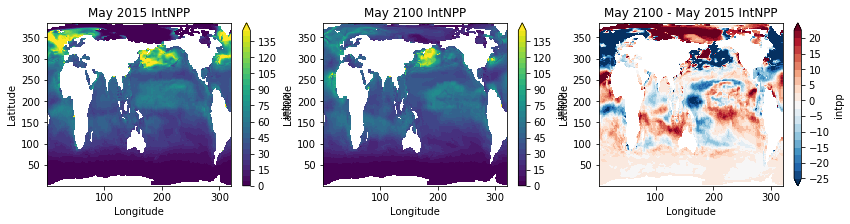

In [20]:
# Make a map of intpp at the start and end of the time series

import numpy as np

levels = np.arange(0, 150, 5)
levels2 = np.arange(-25, 25, 2.5)

fig = plt.figure(figsize=(14, 3))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 3, 1)
(ds_85.intpp*(10**8)).isel(time=4).plot(levels=levels)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.title('May 2015 IntNPP')

ax2 = fig.add_subplot(1, 3, 2)
(ds_85.intpp*(10**8)).isel(time=1031-7).plot(levels=levels)
ax2.set_ylabel('Latitude')
ax2.set_xlabel('Longitude')
plt.title('May 2100 IntNPP')

ax3 = fig.add_subplot(1, 3, 3)
ds_diff = (ds_85.intpp*(10**8)).isel(time=1031-7) - (ds_85.intpp*(10**8)).isel(time=4)
ds_diff.plot(levels=levels2)
ax3.set_ylabel('Latitude')
ax3.set_xlabel('Longitude')
plt.title('May 2100 - May 2015 IntNPP')

In [21]:
ds_85_oa.areacello

<xarray.DataArray 'areacello' (member_id: 1, nlat: 384, nlon: 320)>
dask.array<transpose, shape=(1, 384, 320), dtype=float32, chunksize=(1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_methods:   area: sum
    comment:        TAREA
    description:    Cell areas for any grid used to report ocean variables an...
    frequency:      fx
    id:             areacello
    long_name:      Grid-Cell Area for Ocean Variables
    mipTable:       Ofx
    out_name:       areacello
    prov:           Ofx ((isd.003))
    realm:          ocean
    standard_name:  cell_area
    time_label:     None
    time_title:     No temporal dimensions ... fixed field
    title:          Grid-Cell Area for Ocean Variables
    type:           real
    units:          m2
    variable_id:   

Text(0.5, 0, 'Latitude')

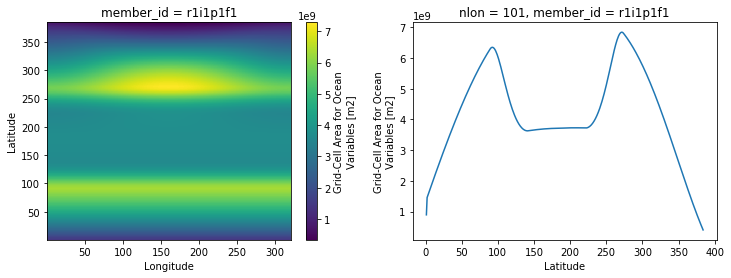

In [22]:
# Make a map of ocean area as well as a meridional plot

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ds_85_oa.areacello.plot()
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

ax2 = fig.add_subplot(1, 2, 2)
ds_85_oa.areacello.isel(nlon=100).plot()
ax2.set_xlabel('Latitude')

# Save Data Frames

#this will allow for easy access in sucessive notebooks

In [23]:
# Check File type
type(ds_hist) 

xarray.core.dataset.Dataset

In [24]:
# Check file size for intpp
print('file size (GB):', ds_hist.nbytes / 1e9) 

file size (GB): 0.979158208


In [25]:
# Check file size for oa
print('file size (GB):', ds_hist_oa.nbytes / 1e9) 

file size (GB): 0.006392608


In [27]:
# Save files to my Cheyenne folder for easy access

ds_hist_mask = ds_hist['intpp'].where(ds_hist['intpp'] < 1e10) 
ds_hist_mask.to_netcdf('Data/hist_intpp_mask.nc') 

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


In [28]:
ds_85_mask = ds_85['intpp'].where(ds_85['intpp'] < 1e10) 
ds_85_mask.to_netcdf('Data/ssp585_intpp_mask.nc') 

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


In [29]:
ds_85_oa_mask = ds_85_oa['areacello'].where(ds_85_oa['areacello'] < 1e10) 
ds_85_oa_mask.to_netcdf('Data/ssp585_oa_mask.nc') 

In [30]:
ds_hist_oa_mask = ds_hist_oa['areacello'].where(ds_hist_oa['areacello'] < 1e10) 
ds_hist_oa_mask.to_netcdf('Data/hist_oa_mask.nc') 

In [31]:
ds_lon.to_netcdf('Data/ds_lon.nc') 
ds_lat.to_netcdf('Data/ds_lat.nc') 